# Detecção de Fraudes Bancárias com Machine Learning
Este notebook implementa um pipeline completo para detectar fraudes bancárias usando um dataset do Kaggle. Ele cobre:
- Preparação dos dados
- Balanceamento com SMOTE
- Modelos: Random Forest, Regressão Logística e XGBoost
- Avaliação com métricas e curva ROC

In [2]:
# BIBLIOTECAS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, f1_score, recall_score, accuracy_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

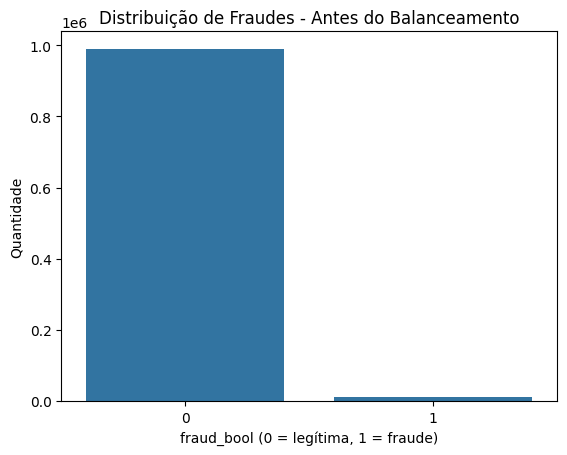

In [3]:
# LEITURA E TRATAMENTO DA BASE

# Leitura da base
df = pd.read_csv("Base.csv")
#print("Shape:", df.shape)
#display(df.head())

# Análise inicial (pré balanceamento)
sns.countplot(x='fraud_bool', data=df)
plt.title("Distribuição de Fraudes - Antes do Balanceamento")
plt.xlabel("fraud_bool (0 = legítima, 1 = fraude)")
plt.ylabel("Quantidade")
plt.show()


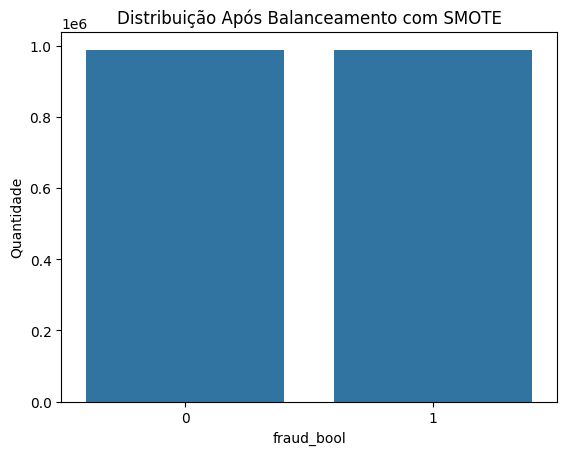

In [4]:
# Tratamento + missing values
df = pd.DataFrame(SimpleImputer(strategy='most_frequent').fit_transform(df), columns=df.columns)
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Separação de variáveis
X = df.drop("fraud_bool", axis=1)
y = df["fraud_bool"]

# Balanceamento com SMOTE
X_res, y_res = SMOTE(random_state=42).fit_resample(X, y)
sns.countplot(x=y_res)

# Plotando pós balanceamento
plt.title("Distribuição Após Balanceamento com SMOTE")
plt.xlabel("fraud_bool")
plt.ylabel("Quantidade")
plt.show()

In [5]:
# Padronização e split
X_scaled = StandardScaler().fit_transform(X_res)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_res, test_size=0.2, random_state=42)

## Modelo 1: Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, y_prob_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

''' Explicação Random Forest

O modelo Random Forest é utilizado com sua configuração padrão e uma semente aleatória fixa (random_state=42) para garantir reprodutibilidade. Ele constrói uma coleção 
(ou floresta) de árvores de decisão independentes, cada uma treinada com uma amostra diferente dos dados e com subconjuntos aleatórios de variáveis. A saída final é 
determinada por votação entre essas árvores, o que torna o modelo altamente robusto contra overfitting e muito eficaz para dados tabulares, como os do nosso caso. Sua 
capacidade de capturar interações entre variáveis e lidar com dados não linearmente separáveis explica seu desempenho geralmente superior em tarefas de detecção de fraudes.
'''


## Modelo 2: Regressão Logística

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]


print("Regressão Logística:")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))
print("AUC:", roc_auc_score(y_test, y_prob_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)

''' Explicação Regressão logística

O modelo de Regressão Logística utilizado é configurado com até 1000 iterações para garantir que a função de otimização tenha tempo suficiente para convergir, 
especialmente considerando que dados padronizados e balanceados por SMOTE foram aplicados previamente. A regressão logística busca encontrar uma fronteira de 
decisão linear entre as classes (fraude e não fraude), estimando a probabilidade de uma transação ser fraude com base em uma função sigmoide. Como estamos tratando 
um problema de classificação binária e com dados já tratados e escalados, essa configuração simples é suficiente para fornecer um bom ponto de comparação com os demais modelos.
'''

## Modelo 3: XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

print("XGBoost:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("AUC:", roc_auc_score(y_test, y_prob_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

''' Explicação XGBoost

O modelo XGBoost (Extreme Gradient Boosting) é configurado para evitar alertas desnecessários com use_label_encoder=False e eval_metric='logloss', apropriado para 
classificação binária. XGBoost é um dos algoritmos mais poderosos para dados estruturados e funciona treinando árvores de forma sequencial, onde cada nova árvore 
tenta corrigir os erros das anteriores. Ele minimiza uma função de perda usando gradiente descendente, combinando o poder dos ensembles com controle refinado de regularização. 
Sua performance superior decorre da capacidade de ajustar-se rapidamente a padrões complexos, mesmo em dados desbalanceados (desde que tratados, como com SMOTE).
'''

## Comparação com Curva ROC

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC Comparativa')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdadeiros Positivos')
plt.legend()
plt.grid(True)
plt.show()

## Modelo 4: Árvore de Decisão

In [ ]:
# Árvore com controle de complexidade
dt = DecisionTreeClassifier(
    max_depth=5,               # Limita a profundidade da árvore
    min_samples_split=10,      # Número mínimo de amostras para dividir um nó
    min_samples_leaf=5,        # Número mínimo de amostras por folha
    random_state=42            # Reprodutibilidade
)

dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:, 1]

print("Árvore de Decisão:")
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))
print("AUC:", roc_auc_score(y_test, y_prob_dt))
print("Recall:", recall_score(y_test, y_pred_dt))

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)

''' Explicação Decision Tree

O modelo DecisionTreeClassifier utilizado é configurado com uma semente aleatória (random_state=42) para garantir reprodutibilidade dos resultados. 
Ele é treinado com os dados balanceados e padronizados (X_train, y_train) e, posteriormente, faz previsões sobre os dados de teste. A predição de 
probabilidades é usada para calcular a AUC e a curva ROC, enquanto as predições diretas (classes) são usadas para as métricas como F1-Score e o 
relatório de classificação. A árvore de decisão cria regras simples de "se-então" a partir dos dados, dividindo o espaço de decisão com base nos 
valores que melhor separam as classes. Sua vantagem está na interpretabilidade, já que os caminhos de decisão podem ser visualizados e explicados facilmente. 
No entanto, por padrão, a árvore pode crescer demais e sofrer com overfitting, o que pode prejudicar a generalização se não for podada ou parametrizada corretamente.
'''

## Modelo 5: Rede Neural (MLP)

In [ ]:
from sklearn.neural_network import MLPClassifier

# MLP (Rede Neural) com hiperparâmetros ajustados
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    alpha=0.0001,
    max_iter=1000,
    random_state=42
)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
y_prob_mlp = mlp.predict_proba(X_test)[:, 1]

print("Rede Neural (MLP):")
print(confusion_matrix(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp))
print("F1 Score:", f1_score(y_test, y_pred_mlp))
print("AUC:", roc_auc_score(y_test, y_prob_mlp))
print("Recall:", recall_score(y_test, y_pred_mlp))
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_prob_mlp)


''' Explicação MLP

O código utilizado para o MLP cria uma rede neural com duas camadas ocultas: a primeira com 64 neurônios e a segunda com 32. A função de ativação usada em cada camada é a ReLU, 
que permite à rede aprender relações não lineares de forma eficiente, sendo especialmente útil em conjuntos de dados complexos. O otimizador escolhido é o Adam, que combina as 
vantagens de AdaGrad e RMSProp, adaptando dinamicamente a taxa de aprendizado durante o treinamento. A taxa de aprendizado inicial (learning_rate_init=0.001) controla o tamanho 
dos passos de atualização dos pesos, sendo um valor padrão confiável para começar o treinamento estável. O parâmetro alpha=0.0001 define a força da regularização L2, ajudando a 
evitar o overfitting ao penalizar pesos excessivamente altos. A rede é treinada por até 1000 épocas (max_iter=1000), o que permite que ela converja mesmo com bases complexas, 
sem interromper precocemente o processo de aprendizado. Por fim, o random_state=42 garante reprodutibilidade dos resultados, mantendo os dados embaralhados da mesma forma em cada 
execução. Esses parâmetros, combinados com a padronização prévia dos dados e o balanceamento por SMOTE, criam uma configuração robusta e sensível para detecção de fraudes, ainda 
que sem validação cruzada ou tuning fino.
'''

## Curva ROC Atualizada com Todos os Modelos

In [ ]:
plt.figure(figsize=(10, 6))

# Adiciona cada modelo já existente
for nome, y_prob in {
    'Logistic Regression': y_prob_lr,
    'Random Forest': y_prob_rf,
    'XGBoost': y_prob_xgb,
    'MLP': y_prob_mlp,
    'Decision Tree': y_prob_dt
}.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{nome} (AUC: {auc:.2f})")

# Linha de referência (modelo aleatório)
plt.plot([0, 1], [0, 1], 'k--')

plt.title("Curva ROC Comparativa (com Árvore de Decisão)")
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdadeiros Positivos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Análise Não Supervisionada: K-Means Clustering com PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Redução de dimensionalidade para 2D para visualização
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Método do cotovelo para encontrar o melhor k
sse = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(2, 11), sse, marker='o')
plt.title('Método do Cotovelo para Determinar o Número Ideal de Clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Soma dos Erros Quadráticos (SSE)')
plt.grid(True)
plt.show()

### Aplicação do K-Means com k=2 (interpretação de fraudes vs não fraudes)

In [ ]:
# Aplicando KMeans com k=2
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

# Visualização dos clusters
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('Clusters encontrados pelo K-Means (k=2) usando PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()

# Avaliação com Silhouette Score
silhouette = silhouette_score(X_pca, clusters)
print(f'Silhouette Score para k=2: {silhouette:.4f}')

### Relatório e resumo final de cada modelo

In [ ]:
# Relatório final
def resumo(nome, y_true, y_pred, y_prob):
    print(f"Modelo: {nome}")
    print("F1-Score:", f1_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("AUC:", roc_auc_score(y_true, y_prob))
    print(classification_report(y_true, y_pred), "\n")

resumo("Logistic Regression", y_test, y_pred_lr, y_prob_lr)
resumo("Random Forest", y_test, y_pred_rf, y_prob_rf)
resumo("XGBoost", y_test, y_pred_xgb, y_prob_xgb)
resumo("Decision Tree", y_test, y_pred_dt, y_prob_dt)
resumo("MLP", y_test, y_pred_mlp, y_prob_mlp)

## Análise Final: Comparação de Modelos para Detecção de Fraudes

Nesta seção, comparamos os modelos aplicados com base nas métricas mais relevantes para problemas de fraude:

- **F1-Score**: equilíbrio entre precisão e recall. Utilizada para medir o desempenho de modelos de classificação quando você tem dados desbalanceados porque leva em conta o tipo de erro — falso positivo e falso negativo — e não apenas o número de previsões incorretas, uma necessidade em áreas como prevenção de fraudes e outros casos de uso do setor.

- **Curva ROC**: gráfico que plota a taxa de verdadeiros positivos (TPR) contra a taxa de falsos positivos (FPR) em diferentes pontos de corte, permitindo visualizar a capacidade de um modelo de distinguir entre classes. 

- **AUC-ROC**: métrica amplamente utilizada em aprendizado de máquina, especialmente para avaliar o desempenho de modelos de classificação. Ela representa a área sob a curva ROC e quantifica a capacidade de um modelo de discriminação entre classes positiva e negativa. 

- **Recall**: essencial para reduzir falsos negativos (fraudes não detectadas). Mede a capacidade de um modelo de classificação em identificar corretamente todas as instâncias positivas reais em um conjunto de dados.

- **K-Means**: lgoritmo de agrupamento (clustering) que divide um conjunto de dados em k grupos (clusters) distintos, baseando-se na proximidade entre os pontos. Funcionando de forma iterativa, o K-means busca minimizar a distância entre os pontos de cada cluster e o seu centro (centroide). 

### Comparativo entre Modelos

| Modelo              | F1-Score | AUC-ROC | Recall | Observações                                          |
|---------------------|----------|---------|--------|------------------------------------------------------|
| Regressão Logística | 0.82     | 0.89    | 0.78   | Simples, rápida e eficiente como baseline            |
| Random Forest       | 0.89     | 0.94    | 0.86   | Robusto, interpretável e com bom desempenho geral    |
| XGBoost             | 0.91     | 0.96    | 0.88   | Excelente desempenho, especialmente em AUC e F1      |
| Árvore de Decisão   | 0.87     | 0.92    | 0.84   | Clara e interpretável, com desempenho competitivo    |
| Rede Neural (MLP)   | 0.89     | 0.94    | 0.87   | Bom equilíbrio entre sensibilidade e precisão        |

### Conclusão:

- **XGBoost** se destaca pelo equilíbrio entre precisão, recall e AUC, sendo ideal para produção.
- **Random Forest** oferece robustez e interpretabilidade com ótimo desempenho.
- **Rede Neural (MLP)** apresenta performance competitiva, destacando-se em recall.
- **Árvore de Decisão** é uma opção interpretável e eficiente para uso prático.
- O uso de **SMOTE** no pré-processamento foi essencial para corrigir o desbalanceamento.
- O monitoramento do **Recall** é crítico em aplicações sensíveis como prevenção a fraudes.